# Imports & Setup

In [8]:
import time 
import itertools 
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco
# import distutils.util
import os
import subprocess



In [7]:
!pip install ffmpeg
!pip install ffmpeg-python

""

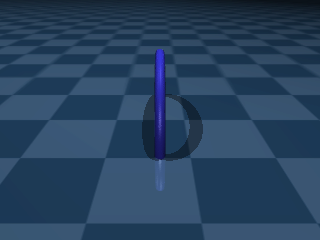

In [2]:
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Defining the wheel here...
xml = """
<mujoco>
  <extension>
    <plugin plugin="mujoco.sdf.torus">
      <instance name="torus">
        <config key="radius1" value="1.5"/>
        <config key="radius2" value="0.10"/>
      </instance>
    </plugin>
  </extension>

  <asset>
    <mesh name="torus">
      <plugin instance="torus"/>
    </mesh>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" rgb2=".2 .3 .4" width="100" height="100"/>
    <material name="grid" texture="grid" texrepeat="32 32" reflectance=".2"/>
  </asset>

  <option sdf_iterations="10" sdf_initpoints="40"/>

  <default>
    <geom solref="0.01 1" solimp=".95 .99 .0001" friction="5"/>
  </default>

  <worldbody>
  <camera name="my_camera" pos="-5 -5 10" euler="30 -20 10"/>

      <geom size="50 50 50" type="plane" material="grid"/>
    <body pos="1 0 0">
      <freejoint/>
      <geom type="sdf" mesh="torus" rgba=".2 .2 .8 1" euler="10 90 90" >
        <plugin instance="torus"/>
      </geom>
      <inertial pos="0 0 0" mass="4" diaginertia="4 4 4"/>
      <camera name="track" pos="0 -6 3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
    <light name="left" pos="-2 0 7" cutoff="80"/>
    <light name="right" pos="2 0 7" cutoff="80"/>
    
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0 -5 1.6 0 0 0 0" qvel="5 5 0 0 0 0" />  #See read.me for d.o.f. z start at 1.6 to be on the ground
  </keyframe>
</mujoco>
"""

xml_path = "cyr_wheel.xml" # Setting the path for the model

model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
# media.show_image(renderer.render())

mujoco.mj_forward(model, data)
renderer.update_scene(data, "track")

media.show_image(renderer.render())

# Definition of Functions

In [19]:
#Specify location of ffmpeg
import os

# Specify the full path to ffmpeg
# ffmpeg_path = "/opt/homebrew/bin/ffmpeg"
ffmpeg_path = ".venv/lib/python3.12/site-packages/ffmpeg-1.4.dist-info"

# Update the PATH environment variable to include the directory containing ffmpeg
os.environ['PATH'] += os.pathsep + os.path.dirname(ffmpeg_path)


In [22]:
def render(xml, duration, framerate, camera):
    model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

    data = mujoco.MjData(model)

    # Make renderer, render and show the pixels
    renderer = mujoco.Renderer(model)
    # media.show_image(renderer.render())

    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    media.show_image(renderer.render())

    # Simulate and display video.
    frames = []
    mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera)
            pixels = renderer.render()
            frames.append(pixels)

    media.show_video(frames, fps=framerate)
    media.write_video('v.mp4', frames, fps=60, qp=18)

""

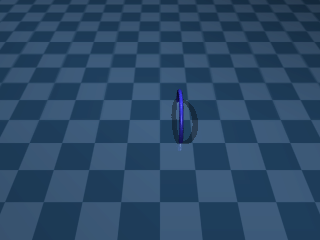

/var/folders/rk/g3gqh7090yqc7kf17z559cq00000gn/T/ipykernel_73361/279930794.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(frame) for frame in frames]


OSError: Cannot understand given URI: array([[[  0,   0,   0],
        [  0,   0,   0],
       ....

In [23]:
render(xml, 7, 20, "track")

# Contact forces

In [6]:
n_frames = 400
height = 240
width = 320
frames = []
renderer = mujoco.Renderer(model, height, width)

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3



# simulate and render
mujoco.mj_resetDataKeyframe(model, data, 0)
for i in range(n_frames):
  while data.time < i/30: #1/4x real time by dividing by 120
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "track", options)
  frame = renderer.render()
  frames.append(frame)

# show video
media.show_video(frames, fps=30)

RuntimeError: Error writing '/var/folders/rk/g3gqh7090yqc7kf17z559cq00000gn/T/tmpd0ucz_ro/file.mp4': Unrecognized option 'qp'.
Error splitting the argument list: Option not found


Trying to get the contact point. Almost there but need to finish this up

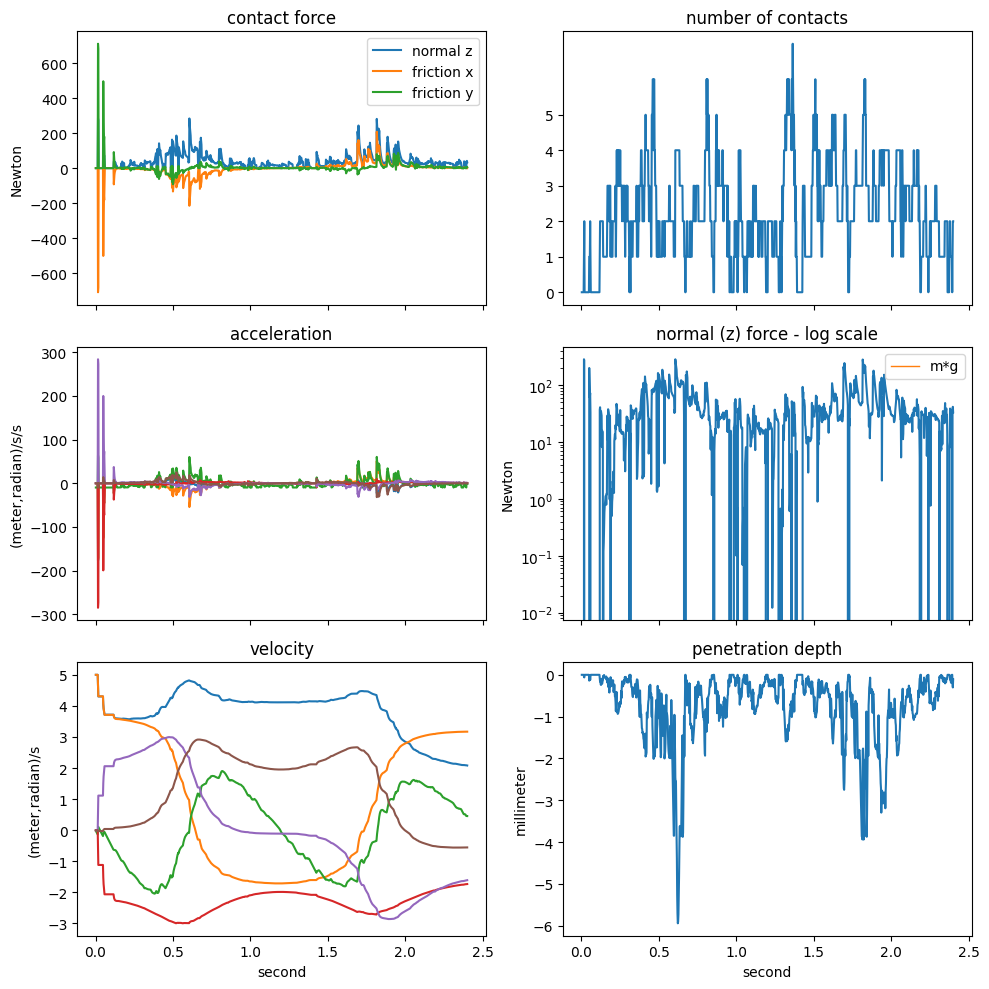

In [143]:
n_steps = 1200

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps) #number of contacts
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)
contacts = []

'''
# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)
'''
mujoco.mj_resetDataKeyframe(model, data, 0) #set frame to frame 0 with init parametrs as defined in xml

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon

  #average position of contact forces
  contacts.append(data.contact.pos) #np.mean(data.contact.pos, axis = 0) #data.contact.pos contains [x,y,z] positions for every contact point, here we average the contact points 

  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("world").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')


plt.tight_layout()



In [148]:
mean_pos = []

for i in range(len(sim_time)):
    mean_pos.append( np.mean(contacts[i], axis = 0) )

mean_position = np.array(mean_pos)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


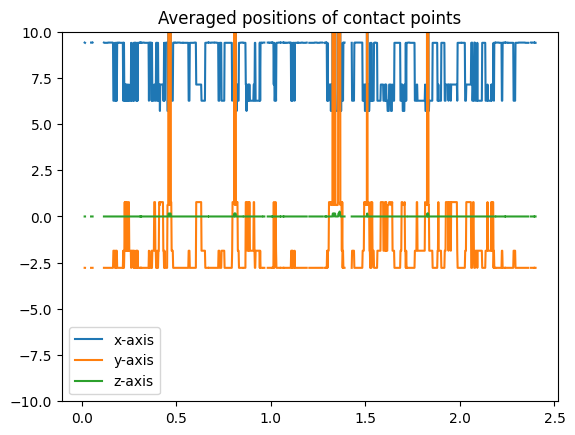

In [145]:
plt.plot(sim_time, mean_position[:,0], label = "x-axis")

plt.plot(sim_time, mean_position[:,1], label = "y-axis")
plt.plot(sim_time, mean_position[:,2], label = "z-axis")
plt.title("Averaged positions of contact points")
# plt.xlim(1.77,1.8)
plt.ylim(-10,10)
plt.legend()

In [131]:
contacts

[array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array([[ 0.004,  1.642, -0.   ],
        [-0.018,  1.758, -0.002]]),
 array(